# 在最后fc前拼接bci2a元数据训练EGGNet
### 11.02 元信息种类越多，越能接近无元信息的准确率

## 数据集初始化

In [1]:
import torch
import numpy as np
import pickle
import os
import time
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import math

# --- 1. PyTorch 数据集类 (Dataset Class) ---
# 定义一个继承自 torch.utils.data.Dataset 的自定义数据集类
class BCI2aDataset(torch.utils.data.Dataset):
    # 类的初始化方法，在创建对象时调用
    def __init__(
        self,
        data_path: str,  # 数据文件路径 (例如 "A01T.pkl")
        transform=None    # 可选的数据转换（增强）函数
    ):
        # --- 基础属性 ---
        # 从文件路径中提取受试者名称 (例如 "A01T")
        self.subjectName = os.path.splitext(os.path.basename(data_path))[0]
        # 存储传入的数据转换函数
        self.transform = transform
        # 硬编码的通道名称列表，与数据预处理时一致
        self.chan_name = ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4',
                          'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz']

        # --- 加载预处理好的 Pickle 数据 ---
        # "rb" 表示以二进制只读模式打开文件
        with open(data_path, "rb") as f:
            # 使用 pickle.load 从文件中加载数据
            sub_data = pickle.load(f)
            
            # --- 数据和标签的赋值 ---
            # 检查是否传入了 transform 函数
            if self.transform:
                # 如果有，先对数据 (sub_data['x']) 应用转换
                self.data = torch.from_numpy(self.transform(sub_data['x'])).type(torch.FloatTensor)
            else:
                # 如果没有，直接将 numpy 数组转换为 Float Tensor
                self.data = torch.from_numpy(sub_data['x']).type(torch.FloatTensor)
            
            # 加载标签 (y)
            self.labels = sub_data['y']
            # 加载伪影标记 (artifacts)，并转换为 Float Tensor
            self.artifacts = torch.tensor(sub_data['artifacts'], dtype=torch.float32)
            # 加载场次信息 (session)，并转换为 Float Tensor
            self.sessions = torch.tensor(sub_data['session'], dtype=torch.float32)
            # 加载性别信息 (gender)，并转换为 Float Tensor
            self.gender = torch.tensor(sub_data['gender'], dtype=torch.float32)
            # 加载年龄信息 (age)，并转换为 Float Tensor
            self.age = torch.tensor(sub_data['age'], dtype=torch.float32)
            
    # --- 必须实现的 __len__ 方法 ---
    def __len__(self):
        # 返回数据集中样本的总数
        return len(self.labels)

    # --- 必须实现的 __getitem__ 方法 ---
    def __getitem__(self, i):
        # 根据索引 i 获取单个数据样本
        # 注意：标签减 1，将原始的 [1, 2, 3, 4] 标签转换为 PyTorch 期望的 [0, 1, 2, 3]
        return self.data[i], self.labels[i]-1, self.artifacts[i], self.sessions[i], self.gender, self.age

In [2]:
# --- 实例化数据集 ---
# 创建训练集对象
train_dataset = BCI2aDataset(data_path="/lustre1/project/stg_00160/EEG_LLM/A01T.pkl")
# 创建测试集对象
test_dataset = BCI2aDataset(data_path="/lustre1/project/stg_00160/EEG_LLM/A01E.pkl")

## 模型设置

In [3]:
"""
EEGNet: 

EEGNet: A Compact Convolutional Network for EEG-based Brain-Computer Interfaces

"""

# down sample 128Hz
import torch.nn as nn
import torch
import torch.nn.functional as F
import math

# --- 2. EEGNet 模型定义 ---

# --- 2.1 辅助模块: 可分离卷积 ---
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, bias=False):
        super(SeparableConv2d, self).__init__()
        # 深度卷积: groups=in_channels 表示每个输入通道独立进行卷积
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                     groups=in_channels, bias=bias, padding='same')
        # 逐点卷积: 1x1 卷积核，用于混合通道信息
        self.pointwise = nn.Conv2d(in_channels, out_channels, 
                                     kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)  # 先进行深度卷积
        # print("sepcov2d-depth",out.shape)
        out = self.pointwise(out) # 再进行逐点卷积
        # print("sepcov2d-point",out.shape)
        return out
    
# --- 2.2 辅助模块: 带最大范数约束的全连接层 ---
class MaxNormLinear(nn.Module):
    def __init__(self, inchannel, outchannel):
        super(MaxNormLinear, self).__init__()
        self.linear = nn.Linear(inchannel, outchannel)
        self._eps = 1e-7  # 一个很小的数，防止除零
        
    def max_norm(self):
        # 在不计算梯度的上下文中执行，以进行权重修改
        with torch.no_grad():
            # 计算每个神经元（dim=0）权重的L2范数
            norm = self.linear.weight.norm(2, dim=0, keepdim=True)
            # 期望的范数，限制在0到0.25之间
            desired = torch.clamp(norm, 0, 0.25)
            # 计算缩放因子并更新权重
            self.linear.weight = torch.nn.Parameter( (self.linear.weight * (desired / (self._eps + norm))), dtype=torch.float, device="cuda")
    
    def forward(self, x):
        self.max_norm()  # 在每次前向传播时应用约束
        return self.linear(x)
        
# --- 2.3 辅助模块: 带最大范数约束的卷积层 ---
class ConstrainedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, no_groups, if_bias):
        super(ConstrainedConv2d, self).__init__()
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size,
                                 groups=no_groups, bias=if_bias)  # 空间滤波器 22通道=>3通道
    def max_norm(self):
        
        # 计算每个输出通道（dim=0）的L2范数
        norm = self.conv2.weight.norm(2, dim=0, keepdim=True)
        # 期望的范数，限制在0到1.0之间
        desired = torch.clamp(norm, 0, 1.0)
        # 计算缩放因子并更新权重
        self.conv2.weight = torch.nn.Parameter( (self.conv2.weight * (desired / (1e10-7 + norm)))).to("cuda")
    
    def forward(self, input):
        self.max_norm()  # 在每次前向传播时应用约束
        return self.conv2(input)  
    
# --- 2.4 EEGNet 主模型定义 ---
class EEGNet(nn.Module):
    def __init__(self, no_spatial_filters, no_channels, no_temporal_filters, temporal_length_1, temporal_length_2, window_length, num_class, drop_out_ratio=0.50, pooling2=4, pooling3=8, inputMeta=0):
        super(EEGNet, self).__init__()
        self.drop_out_ratio = drop_out_ratio
        self.inputMeta = inputMeta
        
        # --- 第1层: 时间卷积 (模拟带通滤波器) ---
        # 卷积核 (1, temporal_length_1) 只在时间维度上卷积
        self.conv1 = nn.Conv2d(1, no_temporal_filters, (1, temporal_length_1), padding='same', bias=False)
        self.batchnorm1 = nn.BatchNorm2d(no_temporal_filters, False)  # 批归一化
        self.dropout = nn.Dropout(self.drop_out_ratio)  # Dropout层
        
        # --- 第2层: 深度空间卷积 (学习空间滤波器) ---
        # 卷积核 (no_channels, 1) 只在通道维度上卷积
        # groups = no_temporal_filters 表示这是一个深度卷积
        self.conv2 = nn.Conv2d(no_temporal_filters, no_temporal_filters * no_spatial_filters, (no_channels, 1),
                                 groups=no_temporal_filters, bias=False)  # 空间滤波器
        self.batchnorm2 = nn.BatchNorm2d(no_temporal_filters * no_spatial_filters, False)
        self.pooling2 = nn.AvgPool2d(1, pooling2)  # 平均池化，降低时间分辨率 (e.g., 128Hz -> 32Hz)
        
        # --- 第3层: 可分离卷积 (学习时空特征) ---
        self.separableConv2 = SeparableConv2d(no_temporal_filters * no_spatial_filters,
                                              no_temporal_filters * no_spatial_filters, (1, temporal_length_2))
        self.batchnorm3 = nn.BatchNorm2d(no_temporal_filters * no_spatial_filters, False)

        self.pooling3 = nn.AvgPool2d((1, pooling3))  # 第二次池化
        
        # --- 全连接层 ---
        # 创建一个假的EEG输入，用于自动计算全连接层的输入维度
        eeg_random = torch.randn(4, no_channels, window_length)
        # 调用辅助函数计算压平后的特征长度
        fc_length = self.calc_fc_features(eeg_random)
        # bin(self.inputMeta).count('1') 会计算数字的二进制中有多少个 '1'
        # 例如: inputMeta = 12 (二进制 1100) -> .count('1') 结果为 2
        num_meta_features = bin(self.inputMeta).count('1')
        print(f"--- 模型初始化: inputMeta={self.inputMeta}, 将拼接 {num_meta_features} 个元数据特征 ---")
        # 定义全连接层
        # 注意：输入维度 = EEG特征长度 + 4 (来自4个元数据)
        #Tag修改拼接元信息
        self.fc1 = nn.Linear(fc_length + num_meta_features, num_class)

        
    
    # --- 辅助函数: 自动计算全连接层输入维度 ---
    def calc_fc_features(self, x,): # 注意：您这里有一个多余的逗号
        self.eval()  # 切换到评估模式 (Dropout 和 BatchNorm 会改变行为)
        with torch.no_grad():  # 禁用梯度计算
            # 完整模拟一次前向传播 (不包含元数据)
            x = torch.unsqueeze(x, 1)
            x = self.conv1(x)
            x = self.batchnorm1(x)
            x = self.conv2(x)
            B, FB, Ch, TL = x.shape
            x = torch.reshape(x, (B, FB * Ch, 1, TL))
            x = nn.functional.elu(self.batchnorm2(x))
            x = self.pooling2(x)
            x = self.dropout(x)
            x = self.separableConv2.forward(x)
            x = nn.functional.elu(self.batchnorm3(x))
            x = self.pooling3(x)
            x = self.dropout(x)
            # 将特征图压平成一维向量
            x = torch.flatten(x, start_dim=1)
            # 返回压平后向量的长度
            return x.shape[-1]
    
    # --- 辅助函数: 动态设置Dropout率 ---
    def set_drop_out(self, new_dropout):
        self.dropout.rate = new_dropout
            
    # --- 核心: 前向传播 ---
    # 注意：forward方法现在接收EEG数据和四个元数据作为输入
    def forward(self, x, artifact, session, gender, age):
        # --- 第1层 ---
        # print("input",x.shape)
        # 增加一个维度 (B, C, L) -> (B, 1, C, L)
        x = torch.unsqueeze(x, 1)
        # print(x.shape)
        x = self.conv1(x)
        # print(x.shape)
        x = self.batchnorm1(x)
        
        # --- 第2层 ---
        # print("cov1",x.shape)
        x = self.conv2(x)
        # print("conv2", x.shape)
        B, FB, Ch, TL = x.shape
        # 调整形状以适应后续层
        x = torch.reshape(x, (B, FB * Ch, 1, TL))
        x = nn.functional.elu(self.batchnorm2(x))  # 激活
        x = self.pooling2(x)  # 池化
        x = self.dropout(x)  # Dropout

        # --- 第3层 ---
        # print("pooling2",x.shape)
        x = self.separableConv2.forward(x)
        # print("cov3",x.shape)

        x = nn.functional.elu(self.batchnorm3(x))
        x = self.pooling3(x)
        # print("pooling3",x.shape)
        x = self.dropout(x)
        
        # --- 分类层 ---
        # print("before flatten",x.shape)
        # G特征
        x = torch.flatten(x, start_dim=1)
        # print("fc",x.shape)
        # print(x.shape, artifact.shape, session.shape, gender.shape, age.shape)

        # *** 关键步骤: 拼接元数据 ***
        # 1. 创建一个列表，始终包含EEG特征
        features_to_concat = [x]
        # 2. 使用按位与 (&) 运算符检查开关
        if self.inputMeta & 1:  # 检查 artifact (0001)
            features_to_concat.append(artifact)
            
        if self.inputMeta & 2:  # 检查 session (0010)
            features_to_concat.append(session)
            
        if self.inputMeta & 4:  # 检查 gender (0100)
            features_to_concat.append(gender)
            
        if self.inputMeta & 8:  # 检查 age (1000)
            features_to_concat.append(age)

        # 3. 拼接所有被选中的特征
        x = torch.cat(features_to_concat, dim=-1)
        
        # 全连接层处理拼接后的向量
        x = self.fc1(x)
        return x

## 运行一次

In [4]:
import torch
from torch.utils.data import DataLoader
import random

def set_seed(seed):
    """设置所有随机种子以确保结果可复现"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 选择一个您喜欢的数字作为种子
SEED_VALUE = 42  # 42是一个常用的惯例
set_seed(SEED_VALUE)

# --- 3. 实例化模型 ---
# 使用定义的超参数创建一个EEGNet模型的实例
eegnet = EEGNet(
    no_spatial_filters=4,   # 空间滤波器数量 (D)
    no_channels=22,         # EEG通道数
    no_temporal_filters=8,  # 时间滤波器数量 (F1)
    temporal_length_1=64,   # 第一个时间卷积核长度
    temporal_length_2=16,   # 第二个时间卷积核长度 (在SeparableConv中)
    window_length=int(4*128), # 窗口长度 (512个点)
    num_class=4,            # 类别数
    drop_out_ratio=0.50,    # Dropout比率
    pooling2=4,             # 第二层池化核大小
    pooling3=8,              # 第三层池化核大小
    inputMeta=0
)

--- 模型初始化: inputMeta=0, 将拼接 0 个元数据特征 ---


/data/leuven/379/vsc37996/miniconda3/envs/test1/lib/python3.11/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1027.)
  return F.conv2d(


Epoch 001 | train_loss: 1.4033  train_acc: 25.00% | test_loss: 1.3737    test_acc: 30.90%
Epoch 002 | train_loss: 1.3328  train_acc: 35.07% | test_loss: 1.3513    test_acc: 37.85%
Epoch 003 | train_loss: 1.2706  train_acc: 43.40% | test_loss: 1.3223    test_acc: 39.93%
Epoch 004 | train_loss: 1.2518  train_acc: 40.97% | test_loss: 1.2923    test_acc: 42.01%
Epoch 005 | train_loss: 1.2114  train_acc: 46.88% | test_loss: 1.2657    test_acc: 45.83%
Epoch 006 | train_loss: 1.1350  train_acc: 49.31% | test_loss: 1.2451    test_acc: 46.18%
Epoch 007 | train_loss: 1.1264  train_acc: 53.82% | test_loss: 1.2255    test_acc: 47.57%
Epoch 008 | train_loss: 1.1180  train_acc: 55.56% | test_loss: 1.2082    test_acc: 47.22%
Epoch 009 | train_loss: 1.0680  train_acc: 58.68% | test_loss: 1.1943    test_acc: 47.22%
Epoch 010 | train_loss: 1.0472  train_acc: 57.64% | test_loss: 1.1804    test_acc: 48.26%
Epoch 011 | train_loss: 0.9877  train_acc: 62.15% | test_loss: 1.1685    test_acc: 48.96%
Epoch 012 

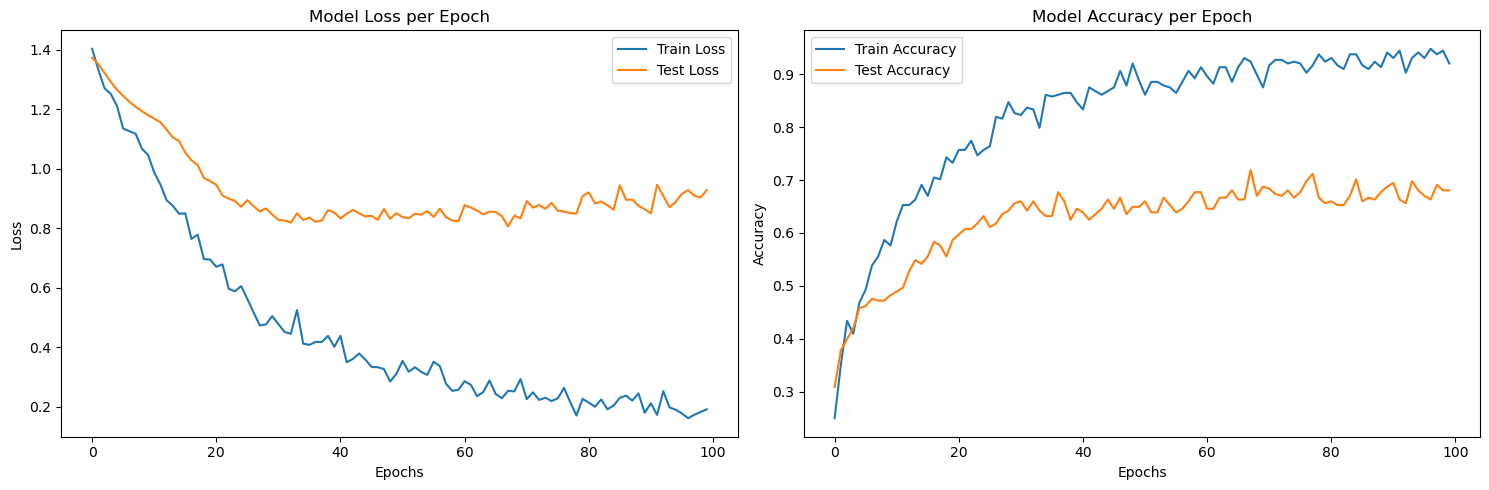

In [8]:
# --- 绘图库导入 ---
import matplotlib.pyplot as plt
# --- config ---
batch_size   = 32
num_workers  = 0
epochs       = 100
lr           = 1e-3
weight_decay = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = eegnet.to(device)

# --- data loaders ---
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=True, drop_last=False
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True, drop_last=False
)

# --- loss & optimizer ---
criterion = torch.nn.CrossEntropyLoss()          # expects logits and int64 labels
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# --- helpers ---
def run_epoch(loader, train: bool):
    if train:
        model.train()
    else:
        model.eval()

    total_loss, total_correct, total_samples = 0.0, 0, 0

    for batch_data in loader:
        x = batch_data[0].to(device, non_blocking=True)
        y = batch_data[1].to(device, non_blocking=True).long() 
        artifact = torch.unsqueeze(batch_data[2],-1).to(device, non_blocking=True)
        session = torch.unsqueeze(batch_data[3],-1).to(device, non_blocking=True)
        gender = torch.unsqueeze(batch_data[4],-1).to(device, non_blocking=True)
        age = torch.unsqueeze(batch_data[5],-1).to(device, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)

        # forward
        logits = model(x,artifact,session,gender,age)                            # shape [B, C]
        loss = criterion(logits, y)

        if train:
            loss.backward()
            optimizer.step()

        # stats
        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total_samples += x.size(0)

    avg_loss = total_loss / max(total_samples, 1)
    acc = total_correct / max(total_samples, 1)
    return avg_loss, acc

# --- training loop ---
best_test_acc = 0.0

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(1, epochs + 1):
    train_loss, train_acc = run_epoch(train_loader, train=True)
    test_loss, test_acc   = run_epoch(test_loader,  train=False)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save({'model': model.state_dict()}, 'best_model.pt')

    print(
        f"Epoch {epoch:03d} | "
        f"train_loss: {train_loss:.4f}  train_acc: {train_acc*100:.2f}% | "
        f"test_loss: {test_loss:.4f}    test_acc: {test_acc*100:.2f}%"
    )

print(f"Best test acc: {best_test_acc*100:.2f}%")

# 创建一个图表 (Figure)，包含1行2列的子图 (Subplots)
# figsize=(15, 5) 设置整个图表的宽度为15英寸，高度为5英寸
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# --- 第一个子图: 损失 (Loss) ---
ax1.plot(train_loss_history, label='Train Loss')  # 绘制训练损失曲线
ax1.plot(test_loss_history, label='Test Loss')    # 绘制测试损失曲线
ax1.set_title('Model Loss per Epoch')             # 设置子图标题
ax1.set_xlabel('Epochs')                          # 设置X轴标签
ax1.set_ylabel('Loss')                            # 设置Y轴标签
ax1.legend()                                      # 显示图例 (区分'Train Loss'和'Test Loss')

# --- 第二个子图: 准确率 (Accuracy) ---
ax2.plot(train_acc_history, label='Train Accuracy')  # 绘制训练准确率曲线
ax2.plot(test_acc_history, label='Test Accuracy')    # 绘制测试准确率曲线
ax2.set_title('Model Accuracy per Epoch')          # 设置子图标题
ax2.set_xlabel('Epochs')                         # 设置X轴标签
ax2.set_ylabel('Accuracy')                       # 设置Y轴标签
ax2.legend()                                     # 显示图例

plt.tight_layout()  # 自动调整子图布局，防止标签重叠
plt.show()          # 在Jupyter Notebook中直接显示图像

## 所有组合都运行一遍

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
import numpy as np
import random

# --- 1. 重构 run_epoch (使其不依赖全局变量) ---
# 这个版本接受 model, optimizer 和 device 作为参数
def run_epoch(loader, train: bool, model, optimizer, criterion, device):
    """
    运行一个完整的 epoch (训练或评估)
    """
    if train:
        model.train()  # 设置模型为训练模式
    else:
        model.eval()   # 设置模型为评估模式

    total_loss, total_correct, total_samples = 0.0, 0, 0

    # 启用或禁用梯度计算
    with torch.set_grad_enabled(train):
        for batch_data in loader:
            # 将所有数据移动到GPU
            x = batch_data[0].to(device, non_blocking=True)
            y = batch_data[1].to(device, non_blocking=True).long() 
            artifact = torch.unsqueeze(batch_data[2], -1).to(device, non_blocking=True)
            session = torch.unsqueeze(batch_data[3], -1).to(device, non_blocking=True)
            gender = torch.unsqueeze(batch_data[4], -1).to(device, non_blocking=True)
            age = torch.unsqueeze(batch_data[5], -1).to(device, non_blocking=True)

            # --- 训练步骤 ---
            if train:
                optimizer.zero_grad(set_to_none=True)  # 清空梯度

            # --- 前向传播 ---
            logits = model(x, artifact, session, gender, age)
            loss = criterion(logits, y)

            # --- 训练步骤 ---
            if train:
                loss.backward()  # 反向传播
                optimizer.step() # 更新权重

            # --- 统计结果 ---
            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total_samples += x.size(0)

    # 计算平均损失和准确率
    avg_loss = total_loss / max(total_samples, 1)
    acc = total_correct / max(total_samples, 1)
    return avg_loss, acc

# --- 2. 辅助函数: 将元数据代码转换为名称 ---
def get_meta_names(meta_code):
    """
    将位掩码 (0-15) 转换成可读的字符串
    """
    names = []
    if meta_code & 1: names.append("artifact")
    if meta_code & 2: names.append("session")
    if meta_code & 4: names.append("gender")
    if meta_code & 8: names.append("age")
    
    if not names:
        return "no meta data"
    return ", ".join(names)

# --- 3. 主实验循环 ---

# 假设这些变量已在之前的单元格中定义:
# SEED_VALUE, train_dataset, test_dataset, device, 
# batch_size, num_workers, epochs, lr, weight_decay
print("--- 开始自动化元数据实验 ---")
print(f"将运行 {epochs} 轮训练, 共 16 种组合。\n")

# 用于存储所有实验结果的字典
results_summary = {}

# 循环 16 次 (inputMeta 从 0 到 15)
for meta_code in range(16):
    
    combination_name = get_meta_names(meta_code)
    print(f"--- 正在测试组合 {meta_code}/15: [{combination_name}] ---")
    
    # --- 1. 重置随机种子 ---
    # 这一步至关重要，确保每个实验都从相同的、可复现的权重开始
    set_seed(SEED_VALUE)

    # --- 2. 实例化新模型 ---
    # (假设 EEGNet 类已在上一单元格定义)
    current_model = EEGNet(
        no_spatial_filters=4, no_channels=22, no_temporal_filters=8,
        temporal_length_1=64, temporal_length_2=16, 
        window_length=int(4*128), num_class=4,
        drop_out_ratio=0.50, pooling2=4, pooling3=8,
        inputMeta=meta_code  # <-- 传入当前的元数据组合代码
    ).to(device)

    # --- 3. 为新模型创建优化器和加载器 ---
    # (假设 train_dataset 和 test_dataset 已在上一单元格定义)
    # (我们重置 data_loader_generator 来确保数据 shuffle 顺序也一致)
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True, drop_last=False,
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True, drop_last=False
    )
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(current_model.parameters(), lr=lr, weight_decay=weight_decay)
    
    best_test_acc = 0.0

    # --- 4. 运行完整的训练循环 ---
    for epoch in range(1, epochs + 1):
        # 注意: 我们将 current_model, optimizer 等作为参数传入
        train_loss, train_acc = run_epoch(train_loader, train=True, 
                                          model=current_model, optimizer=optimizer, 
                                          criterion=criterion, device=device)
        
        test_loss, test_acc = run_epoch(test_loader, train=False, 
                                        model=current_model, optimizer=optimizer, 
                                        criterion=criterion, device=device)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
        
        # 减少打印输出，只在最后几轮打印
        if epoch % (epochs // 4) == 0 or epoch == epochs or epoch == 1:
            print(f"  Epoch {epoch:03d} | "
                  f"test_loss: {test_loss:.4f} | "
                  f"test_acc: {test_acc*100:.2f}% (Best: {best_test_acc*100:.2f}%)")

    # --- 5. 存储这一组合的最佳结果 ---
    results_summary[combination_name] = best_test_acc
    print(f"组合 [{combination_name}] 的最佳准确率: {best_test_acc*100:.2f}%\n")


# --- 6. 打印最终的总结报告 ---
print("\n" + "="*40)
print("       实验总结报告 (Best Test Acc)       ")
print("="*40)

# 对结果进行排序，从高到低
sorted_results = sorted(results_summary.items(), key=lambda item: item[1], reverse=True)

for name, acc in sorted_results:
    print(f"{acc*100:6.2f}%  -  {name}")


--- 开始自动化元数据实验 ---
将运行 100 轮训练, 共 16 种组合。

--- 正在测试组合 0/15: [no meta data] ---
--- 模型初始化: inputMeta=0, 将拼接 0 个元数据特征 ---
  Epoch 001 | test_loss: 1.3737 | test_acc: 30.90% (Best: 30.90%)
  Epoch 025 | test_loss: 0.8728 | test_acc: 63.19% (Best: 63.19%)
  Epoch 050 | test_loss: 0.8510 | test_acc: 64.93% (Best: 67.71%)
  Epoch 075 | test_loss: 0.8850 | test_acc: 66.67% (Best: 71.88%)
  Epoch 100 | test_loss: 0.9283 | test_acc: 68.06% (Best: 71.88%)
组合 [no meta data] 的最佳准确率: 71.88%

--- 正在测试组合 1/15: [artifact] ---
--- 模型初始化: inputMeta=1, 将拼接 1 个元数据特征 ---
  Epoch 001 | test_loss: 1.3638 | test_acc: 37.15% (Best: 37.15%)
  Epoch 025 | test_loss: 1.1469 | test_acc: 51.04% (Best: 53.12%)
  Epoch 050 | test_loss: 1.0587 | test_acc: 57.99% (Best: 58.68%)
  Epoch 075 | test_loss: 1.0608 | test_acc: 59.72% (Best: 62.15%)
  Epoch 100 | test_loss: 1.1496 | test_acc: 58.68% (Best: 62.15%)
组合 [artifact] 的最佳准确率: 62.15%

--- 正在测试组合 2/15: [session] ---
--- 模型初始化: inputMeta=2, 将拼接 1 个元数据特征 ---
  Epoch 001